In [1]:
import contextlib
from datetime import datetime
from fastai import *
from fastai.tabular import *
import io
import pandas as pd
from pathlib import Path
import random

In [2]:
DATA_PATH = Path('../../data/interim')
path = Path('../../models/')

In [3]:
# Import train_valid_data and test_data dataframes
train_valid_df_raw = pd.read_csv(DATA_PATH/'train_valid_data.csv', low_memory=False)
#test_df_raw = pd.read_csv(DATA_PATH/'test_data.csv', low_memory=False)

train_valid_df = train_valid_df_raw.copy()
#test_df = test_df_raw.copy()

train_valid_df.sort_values('date')

# Drop week_start as that will get taken into account by add_datepart() for date
train_valid_df.drop('week_start', axis='columns', inplace=True)
#test_df.drop('week_start', axis='columns', inplace=True)

# Drop any rows where sales = 0 since we don't need to forecast those
train_valid_df = train_valid_df[train_valid_df.sales != 0]
#test_df = test_df[test_df.sales != 0]

# Run tabular.add_datepart() on both dfs to add columns about the date: ['Year', 'Month', 'Week', 'Day', 'Dayofweek',
# 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
tabular.add_datepart(train_valid_df, 'date', drop=True, time=False)
#tabular.add_datepart(test_df, 'date', drop=True, time=False)

# Category names, to which we'll apply embeddings
cat_names = ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']

# Add the date-related categories
cat_names += ['Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
              'Is_year_start', 'Month', 'Week', 'Year',]

# Continuous-variable names, which we'll make sure are all represented as floats
# Just use set difference to make sure everything is covered
cont_names = list(set(train_valid_df.columns) - set(cat_names))

# Set up transforms to 1) replace missing values for continuous variables by the median column value, 2) transform all
# categorical variables into categories, 3) normalize continuous variables.
# Note that FillMissing should do nothing since we shouldn't have any NaNs -- leaving it in anyway
procs = [FillMissing, Categorify, Normalize]

df = train_valid_df

# Feed zeros for sales to the model to be sure we're not cheating
#test_df['sales'] = 0.0

# Validation set is 
valid_idx = range(int(0.8 * len(df)), len(df))
dep_var = 'sales'
print(valid_idx)
print(len(df))
#print(len(test_df))

data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   #.add_test(TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names))
                   .databunch())

data.show_batch()

range(643244, 804056)
804056


assortment,events,promo_interval,state,state_holiday,store_type,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,mean_visibility_km,min_sea_level_pressureh_pa,school_holiday,promo2_since_week,competition_open_since_month,customers,min_temperature_c,Elapsed,mean_temperature_c,precipitationmm,cloud_cover,max_gust_speed_km_h,max_temperature_c,Dayofyear,competition_open_since_year,max_visibility_km,competition_distance,min_dew_point_c,max_wind_speed_km_h,mean_humidity,trend,open,max_humidity,mean_dew_point_c,day_of_week,sales,promo2_since_year,dew_point_c,promo,wind_dir_degrees,mean_wind_speed_km_h,min_visibility_km,min_humidity,promo2,max_sea_level_pressureh_pa,mean_sea_level_pressureh_pa,store,target
c,No Events,None,SH,0,a,2,2,False,False,False,False,False,False,4,14,2014,-1.2736,-0.7003,-0.4785,-0.0432,1.0660,-0.5280,-0.5540,0.0943,0.0574,-0.3089,1.6530,0.0084,0.5110,-0.6604,1.0329,-1.4320,-0.5778,-0.1614,-1.0555,-0.1442,-0.8599,0.0000,0.8369,0.0803,-0.3021,-0.0239,0.0256,0.1841,1.1118,-0.6465,-0.4113,-1.1269,-0.6130,-0.9677,-0.5629,-0.7455,0.7927,8.854808
a,Rain,None,SH,0,a,17,3,False,False,False,False,False,False,10,42,2013,-0.8337,-1.3707,2.0899,-0.0432,1.4481,-0.4825,0.5459,-0.5552,0.1979,-0.3089,0.3780,0.6362,-0.0902,1.2371,0.6334,-1.4320,-0.6668,1.0138,1.2958,1.2434,0.0938,0.0000,0.8369,0.7554,0.2777,-1.1678,0.0256,0.5133,-0.8994,0.5474,0.9185,-0.9059,1.8784,-0.9677,-1.5507,-1.4567,1.3155,8.144389
a,Rain,None,NW,0,a,11,4,False,False,False,False,False,False,10,41,2013,-0.3938,-0.1417,-0.4785,-0.0432,-0.0804,-0.0251,-0.2397,-0.5786,-0.3642,0.5326,1.0155,0.0084,-0.5711,1.1796,-3.7615,0.2987,-0.3509,0.1744,-1.0555,1.0893,-0.0016,0.0000,0.8369,0.0803,0.8574,-0.2663,0.0256,-0.1450,1.1118,-1.2647,-0.7437,-0.2427,1.5225,-0.9677,-0.1924,-0.1528,1.3278,8.740817
a,Fog,None,NW,0,d,22,4,False,False,False,False,False,False,3,12,2013,-0.1739,0.3052,-0.4785,-0.0432,-0.8447,-0.7529,-1.4968,-1.3681,-1.3478,-0.3089,0.3780,0.0084,-1.0521,-0.7658,-1.5641,0.8396,-0.5946,-1.5045,1.1838,0.0100,-0.3831,0.0000,0.5752,-1.4385,0.8574,-0.5416,0.0256,-1.4616,1.1118,-1.2753,0.2536,0.1994,0.0480,-0.9677,0.3015,0.2028,1.4485,8.593227
a,No Events,None,TH,0,d,24,4,False,False,False,False,False,False,4,17,2015,4.2248,-0.1417,-0.4785,-0.0432,0.0054,-0.8666,-0.5540,1.5995,0.1979,-0.3089,0.0920,0.0084,0.6312,-0.4495,-0.0321,0.8396,-0.3741,-0.4972,0.2881,-1.8402,-1.6229,0.0000,-0.8637,-0.5947,0.8574,-0.7776,0.0256,-0.6387,-0.8994,0.3875,0.2536,5.2836,-1.5791,-0.9677,-0.1924,-0.1528,-1.6602,8.446771


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


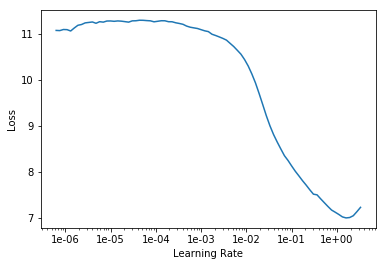

In [4]:
max_y = np.max(df['sales'])
y_range = torch.tensor([0, np.log(max_y*1.2)], device=defaults.device)
learn = tabular_learner(data, layers=[100,100], ps=[0.001, 0.01], emb_drop=0.01, metrics=exp_rmspe, y_range=y_range,
                        callback_fns=[partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe'),
                                      partial(callbacks.tracker.EarlyStoppingCallback, mode='min',
                                              monitor='exp_rmspe', min_delta=0.01, patience=1),
                                      partial(callbacks.tracker.SaveModelCallback, monitor='exp_rmspe', mode='min',
                                              every='improvement',
                                              name=datetime.now().strftime("%Y-%m-%d-%X"))])

learn.lr_find()
learn.recorder.plot()

In [6]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.010255,0.002009,0.041686
2,0.005123,0.000966,0.027100
3,0.007328,0.002429,0.047863


Epoch 4: early stopping


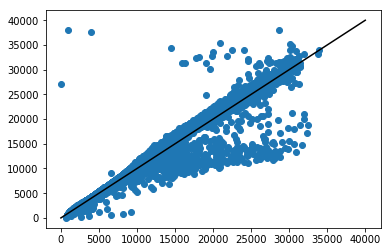

In [7]:
train_log_preds, train_log_reals = learn.get_preds(ds_type=DatasetType.Train)
train_preds = np.exp(train_log_preds).flatten()
train_reals = np.exp(train_log_reals)
train_sub = pd.DataFrame({'Predicted': train_preds, 'Actual': train_reals})
fig, ax = plt.subplots()
ax.scatter(train_sub.Predicted, train_sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

In [5]:
learn.load('2019-02-26-18:15:43-maybe0.0271')

Learner(data=TabularDataBunch;

Train: LabelList
y: FloatList (643244 items)
[FloatItem 8.8321495, FloatItem 8.039803, FloatItem 8.248267, FloatItem 8.617943, FloatItem 8.650849]...
Path: ../../models
x: TabularList (643244 items)
[TabularLine assortment b; events Rain; promo_interval None; state HE; state_holiday a; store_type b; Day 1; Dayofweek 1; Is_month_end False; Is_month_start True; Is_quarter_end False; Is_quarter_start True; Is_year_end False; Is_year_start True; Month 1; Week 1; Year 2013; mean_visibility_km 0.0461; min_sea_level_pressureh_pa -0.7003; school_holiday 2.0899; promo2_since_week -0.0432; competition_open_since_month 0.0054; customers 1.6830; min_temperature_c -0.3969; Elapsed -1.6793; mean_temperature_c -0.5047; precipitationmm 0.5326; cloud_cover 0.3780; max_gust_speed_km_h -1.4888; max_temperature_c -0.6914; Dayofyear -1.5324; competition_open_since_year -0.0321; max_visibility_km 0.8396; competition_distance -0.6435; min_dew_point_c -0.3293; max_wind_speed_km

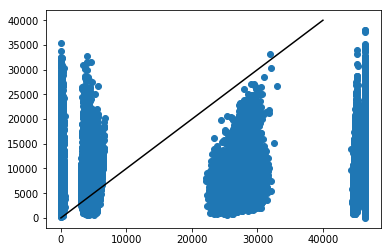

In [6]:
train_log_preds, train_log_reals = learn.get_preds(ds_type=DatasetType.Train)
train_preds = np.exp(train_log_preds).flatten()
train_reals = np.exp(train_log_reals)
train_sub = pd.DataFrame({'Predicted': train_preds, 'Actual': train_reals})
fig, ax = plt.subplots()
ax.scatter(train_sub.Predicted, train_sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

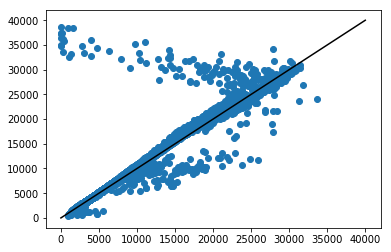

In [8]:
log_preds, log_reals = learn.get_preds(ds_type=DatasetType.Valid)
preds = np.exp(log_preds).flatten()
reals = np.exp(log_reals)
sub = pd.DataFrame({'Predicted': preds, 'Actual': reals})
fig, ax = plt.subplots()
ax.scatter(sub.Predicted, sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

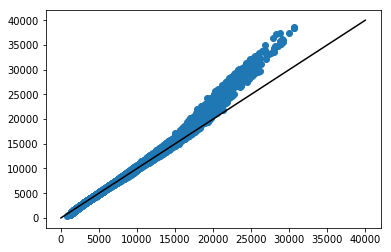

In [13]:
log_preds, log_reals = learn.get_preds(ds_type=DatasetType.Valid)
preds = np.exp(log_preds).flatten()
reals = np.exp(log_reals)
sub = pd.DataFrame({'Predicted': preds, 'Actual': reals})
fig, ax = plt.subplots()
ax.scatter(sub.Predicted, sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

In [8]:
wrongs = sub[np.abs((sub.Predicted - sub.Actual) / sub.Actual) > 0.1]
#wrongs.head()
len(wrongs)/len(sub)
#plt.scatter(wrongs.Predicted, wrongs.Actual)
#exp_rmspe(torch.as_tensor(wrongs.Predicted.values, dtype=torch.float32), torch.as_tensor(wrongs.Actual.values, dtype=torch.float32))
#?exp_rmspe

0.035370494739198566

In [9]:
#exp_rmspe(torch.as_tensor(wrongs.Predicted.values, dtype=torch.float32),
          #torch.as_tensor(wrongs.Actual.values, dtype=torch.float32))
#(torch.as_tensor(wrongs.Predicted.values, dtype=torch.float32))
#(torch.as_tensor(wrongs.Actual.values, dtype=torch.float32))
#exp_rmspe(torch.as_tensor(wrongs.Actual.values, dtype=torch.float32),
          #torch.as_tensor(wrongs.Predicted.values, dtype=torch.float32))
#exp_rmspe(torch.as_tensor([1.]), torch.as_tensor([1.]))

def rmspe(predicted, actual):
    return np.sqrt((((actual - predicted)/actual)**2).sum()/len(actual))

rmspe(sub.Predicted.values, sub.Actual.values)

0.04930551970952587

In [10]:
rmspe(train_sub.Predicted.values, train_sub.Actual.values)

0.05638608818228248

In [12]:
len(test_preds)

40282

In [28]:
learn.data.show_batch(ds_type=DatasetType.Test)

assortment,events,promo_interval,state,state_holiday,store_type,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,competition_distance,mean_sea_level_pressureh_pa,mean_humidity,promo,sales,precipitationmm,cloud_cover,max_humidity,mean_visibility_km,mean_temperature_c,mean_wind_speed_km_h,min_dew_point_c,Elapsed,min_humidity,max_wind_speed_km_h,max_gust_speed_km_h,max_temperature_c,competition_open_since_year,school_holiday,day_of_week,Dayofyear,store,min_visibility_km,trend,min_temperature_c,promo2,promo2_since_week,customers,wind_dir_degrees,dew_point_c,competition_open_since_month,max_sea_level_pressureh_pa,max_visibility_km,min_sea_level_pressureh_pa,mean_dew_point_c,open,promo2_since_year,target
a,Rain,None,HE,#na#,c,20,5,False,False,False,False,False,False,6,25,2015,-0.5069,0.5583,-0.8380,-0.8994,-2.2732,-0.3089,0.3780,-0.7329,-0.1739,0.6195,0.0874,0.3423,1.8212,-0.7147,-0.2717,-1.3370,0.3908,-0.1657,-0.4785,1.4372,0.0967,-1.7376,0.6415,1.9059,0.8602,-0.9677,-0.0432,-0.7175,1.1443,0.1841,0.6838,0.3015,0.8396,0.6404,0.2491,0.0000,0.0256,0
c,Rain,"Mar,Jun,Sept,Dec",HE,#na#,d,20,5,False,False,False,False,False,False,6,25,2015,0.1828,0.5583,-0.8380,-0.8994,-2.2732,-0.3089,0.3780,-0.7329,-0.1739,0.6195,0.0874,0.3423,1.8212,-0.7147,-0.2717,-1.3370,0.3908,0.6334,-0.4785,1.4372,0.0967,-1.5674,0.6415,1.9059,0.8602,1.0334,-1.4670,-0.2804,1.1443,0.1841,-1.6090,0.3015,0.8396,0.6404,0.2491,0.0000,1.9870,0
c,Rain,"Jan,Apr,Jul,Oct",HE,#na#,c,20,5,False,False,False,False,False,False,6,25,2015,-0.5249,0.5583,-0.8380,-0.8994,-2.2732,-0.3089,0.3780,-0.7329,-0.1739,0.6195,0.0874,0.3423,1.8212,-0.7147,-0.2717,-1.3370,0.3908,-0.0321,-0.4785,1.4372,0.0967,-1.5272,0.6415,1.9059,0.8602,1.0334,1.6748,0.4120,1.1443,0.1841,0.0054,0.3015,0.8396,0.6404,0.2491,0.0000,-0.6440,0
c,Rain,"Jan,Apr,Jul,Oct",HE,#na#,d,20,5,False,False,False,False,False,False,6,25,2015,-0.5301,0.5583,-0.8380,-0.8994,-2.2732,-0.3089,0.3780,-0.7329,-0.1739,0.6195,0.0874,0.3423,1.8212,-0.7147,-0.2717,-1.3370,0.3908,0.0341,-0.4785,1.4372,0.0967,-1.5025,0.6415,1.9059,0.8602,1.0334,-1.4670,-0.2298,1.1443,0.1841,0.3017,0.3015,0.8396,0.6404,0.2491,0.0000,1.9870,0
c,Rain,"Jan,Apr,Jul,Oct",HE,#na#,d,20,5,False,False,False,False,False,False,6,25,2015,0.3465,0.5583,-0.8380,-0.8994,-2.2732,-0.3089,0.3780,-0.7329,-0.1739,0.6195,0.0874,0.3423,1.8212,-0.7147,-0.2717,-1.3370,0.3908,-0.0321,-0.4785,1.4372,0.0967,-1.3973,0.6415,1.9059,0.8602,1.0334,1.3606,-0.4497,1.1443,0.1841,0.0054,0.3015,0.8396,0.6404,0.2491,0.0000,-2.3981,0


In [37]:
len(test_preds) # 40282
len(test_real) # 40282
test_preds.mean() # tensor(1049.8042)
test_preds.min() # tensor(1.0054)
test_preds.max() # tensor(1708.7660)

tensor(1708.7660)

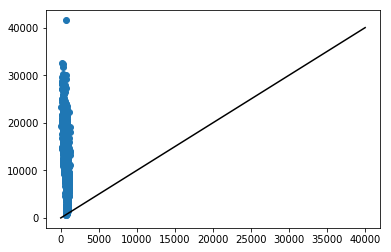

In [42]:
log_test_preds, log_test_reals = learn.get_preds(ds_type=DatasetType.Test)
test_preds = np.exp(log_test_preds).flatten()
#test_reals = np.exp(log_test_reals)
test_reals = test_df_raw.loc[test_df_raw.sales != 0, 'sales'].values


#train_log_preds, train_log_reals = learn.get_preds(ds_type=DatasetType.Train)
#train_preds = np.exp(train_log_preds).flatten()
#train_reals = np.exp(train_log_reals)
#train_sub = pd.DataFrame({'Predicted': train_preds, 'Actual': train_reals})



test_sub = pd.DataFrame({'Predicted': test_preds, 'Actual': test_reals})
fig, ax = plt.subplots()
ax.scatter(test_sub.Predicted, test_sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

In [19]:
rmspe(test_sub.Predicted.values, test_sub.Actual.values)
#test_sub.Actual.min()
#test_sub[test_sub.Actual == 0.0]

1059.8004535161265

In [7]:
import ipdb

# Import train_valid_data and test_data dataframes
#train_valid_df_raw = pd.read_csv(DATA_PATH/'train_valid_data.csv', low_memory=False)
test_df_raw = pd.read_csv(DATA_PATH/'test_data.csv', low_memory=False)

train_valid_df = train_valid_df_raw.copy()
test_df = test_df_raw.copy()

train_valid_df.sort_values('date')

# Drop week_start as that will get taken into account by add_datepart() for date
train_valid_df.drop('week_start', axis='columns', inplace=True)
test_df.drop('week_start', axis='columns', inplace=True)

# Drop any rows where sales = 0 since we don't need to forecast those
train_valid_df = train_valid_df[train_valid_df.sales != 0]
test_df = test_df[test_df.sales != 0]

# Run tabular.add_datepart() on both dfs to add columns about the date: ['Year', 'Month', 'Week', 'Day', 'Dayofweek',
# 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
tabular.add_datepart(train_valid_df, 'date', drop=True, time=False)
tabular.add_datepart(test_df, 'date', drop=True, time=False)

# Category names, to which we'll apply embeddings
cat_names = ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']

# Add the date-related categories
cat_names += ['Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
              'Is_year_start', 'Month', 'Week', 'Year',]

# Continuous-variable names, which we'll make sure are all represented as floats
# Just use set difference to make sure everything is covered
cont_names = list(set(train_valid_df.columns) - set(cat_names))

# Set up transforms to 1) replace missing values for continuous variables by the median column value, 2) transform all
# categorical variables into categories, 3) normalize continuous variables.
# Note that FillMissing should do nothing since we shouldn't have any NaNs -- leaving it in anyway
procs = [FillMissing, Categorify, Normalize]

# Just tack test_df on at the end of train_valid_df, and we'll use test_df as a 'validation' set
# We won't use .fit() on this, just .get_preds()
df = train_valid_df.append(test_df)

# Validation set is 
test_idx = range(len(train_valid_df), len(train_valid_df) + len(test_df))
dep_var = 'sales'
print(test_idx)
print(len(train_valid_df))
print(len(test_df))

#ipdb.set_trace()

test_data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .split_by_idx(test_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())

test_data.show_batch(ds_type=DatasetType.Valid)

range(804056, 844338)
804056
40282


assortment,events,promo_interval,state,state_holiday,store_type,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,mean_visibility_km,min_sea_level_pressureh_pa,school_holiday,promo2_since_week,competition_open_since_month,customers,min_temperature_c,Elapsed,mean_temperature_c,precipitationmm,cloud_cover,max_gust_speed_km_h,max_temperature_c,Dayofyear,competition_open_since_year,max_visibility_km,competition_distance,min_dew_point_c,max_wind_speed_km_h,mean_humidity,trend,open,max_humidity,mean_dew_point_c,day_of_week,sales,promo2_since_year,dew_point_c,promo,wind_dir_degrees,mean_wind_speed_km_h,min_visibility_km,min_humidity,promo2,max_sea_level_pressureh_pa,mean_sea_level_pressureh_pa,store,target
a,Rain,None,HE,#na#,c,20,5,False,False,False,False,False,False,6,25,2015,-0.2167,0.6320,-0.4792,0.0179,0.6697,-0.6726,0.8593,1.7531,0.6089,-0.3088,0.2778,-1.3789,0.3738,0.0973,-0.1399,0.8305,-0.5369,0.3329,-0.1782,-0.8016,1.8640,0.0000,-0.7095,0.2422,1.4383,-0.9200,0.0044,0.1786,-0.9008,1.1418,0.1900,0.5832,-0.6926,-0.9961,0.2878,0.5483,-1.7326,8.31801
c,Rain,"Mar,Jun,Sept,Dec",HE,#na#,d,20,5,False,False,False,False,False,False,6,25,2015,-0.2167,0.6320,-0.4792,-1.3483,-1.5938,-0.2421,0.8593,1.7531,0.6089,-0.3088,0.2778,-1.3789,0.3738,0.0973,0.6719,0.8305,0.1488,0.3329,-0.1782,-0.8016,1.8640,0.0000,-0.7095,0.2422,1.4383,0.7714,1.9128,0.1786,-0.9008,1.1418,0.1900,0.5832,-0.6926,1.0039,0.2878,0.5483,-1.5617,9.143239
c,Rain,"Jan,Apr,Jul,Oct",HE,#na#,c,20,5,False,False,False,False,False,False,6,25,2015,-0.2167,0.6320,-0.4792,1.6663,0.0000,0.4398,0.8593,1.7531,0.6089,-0.3088,0.2778,-1.3789,0.3738,0.0973,-0.0041,0.8305,-0.5549,0.3329,-0.1782,-0.8016,1.8640,0.0000,-0.7095,0.2422,1.4383,-0.0193,-0.6472,0.1786,-0.9008,1.1418,0.1900,0.5832,-0.6926,1.0039,0.2878,0.5483,-1.5213,8.8385515
c,Rain,"Jan,Apr,Jul,Oct",HE,#na#,d,20,5,False,False,False,False,False,False,6,25,2015,-0.2167,0.6320,-0.4792,-1.3483,0.2925,-0.1923,0.8593,1.7531,0.6089,-0.3088,0.2778,-1.3789,0.3738,0.0973,0.0631,0.8305,-0.5600,0.3329,-0.1782,-0.8016,1.8640,0.0000,-0.7095,0.2422,1.4383,0.2257,1.9128,0.1786,-0.9008,1.1418,0.1900,0.5832,-0.6926,1.0039,0.2878,0.5483,-1.4964,8.943245
c,Rain,"Jan,Apr,Jul,Oct",HE,#na#,d,20,5,False,False,False,False,False,False,6,25,2015,-0.2167,0.6320,-0.4792,1.3649,0.0000,-0.4088,0.8593,1.7531,0.6089,-0.3088,0.2778,-1.3789,0.3738,0.0973,-0.0041,0.8305,0.3116,0.3329,-0.1782,-0.8016,1.8640,0.0000,-0.7095,0.2422,1.4383,-0.2948,-2.3539,0.1786,-0.9008,1.1418,0.1900,0.5832,-0.6926,1.0039,0.2878,0.5483,-1.3907,8.705994


In [12]:
test_data.valid_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f9d38d9b1d0>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x7f9cc9fcf8c8>)

In [13]:
learn.validate(dl=test_data.valid_dl)

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
log_test_preds, log_test_reals = learn.get_preds(test_data.test_dl
test_preds = np.exp(log_test_preds).flatten()
test_reals = np.exp(log_test_reals)
#test_reals = test_df_raw.loc[test_df_raw.sales != 0, 'sales'].values
test_sub = pd.DataFrame({'Predicted': test_preds, 'Actual': test_reals})
fig, ax = plt.subplots()
ax.scatter(test_sub.Predicted, test_sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

In [31]:
check = test_df_raw.copy()
check.head()

,store,state,date,max_temperature_c,mean_temperature_c,min_temperature_c,dew_point_c,mean_dew_point_c,min_dew_point_c,max_humidity,...,promo_interval,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,trend,week_start
0,1,HE,2015-06-20,17,14,11,9,7,5,88,...,None,5,4097.0,494.0,1.0,0.0,0,0.0,85,2015-06-14
1,56,HE,2015-06-20,17,14,11,9,7,5,88,...,"Mar,Jun,Sept,Dec",5,9351.0,667.0,1.0,0.0,0,0.0,85,2015-06-14
2,69,HE,2015-06-20,17,14,11,9,7,5,88,...,"Jan,Apr,Jul,Oct",5,6895.0,941.0,1.0,0.0,0,0.0,85,2015-06-14
3,77,HE,2015-06-20,17,14,11,9,7,5,88,...,"Jan,Apr,Jul,Oct",5,7656.0,687.0,1.0,0.0,0,0.0,85,2015-06-14
4,111,HE,2015-06-20,17,14,11,9,7,5,88,...,"Jan,Apr,Jul,Oct",5,6039.0,600.0,1.0,0.0,0,0.0,85,2015-06-14


In [29]:
#log_test_preds, log_test_reals_maybe = learn.get_preds(test_data.valid_dl)
#log_notreal_train_preds, log_notreal_reals = learn.get_preds(test_data.train_dl)
#test_preds = np.exp(log_test_preds)
#test_reals_maybe = np.exp(log_test_reals_maybe)
#len(test_reals_maybe) # 643244
#len(log_notreal_train_preds) # 643244
#log_notreal_train_preds, log_notreal_reals = learn.get_preds(test_data.test_dl)
#len(log_notreal_reals) # 643244
#log_notreal_train_preds, log_notreal_reals = get_preds(model=learn.model, dl=test_data.valid_dl)
test_data.valid_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f3d4bd58e10>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x7f3d69e07a60>)

In [42]:
learn.validate(learn.data.train_dl)

[0.0007987996, tensor(0.0276)]

In [43]:
learn.validate(learn.data.valid_dl)

[0.0011183583, tensor(0.0303)]

In [44]:
exp(0.001183583)

1.0011842837107814

In [45]:
str(learn.metrics)

'[<function exp_rmspe at 0x7f3b726f97b8>]'

In [47]:
learn.show_results(DatasetType.Valid)

assortment,events,promo_interval,state,state_holiday,store_type,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,max_temperature_c,sales,max_gust_speed_km_h,min_dew_point_c,min_sea_level_pressureh_pa,mean_visibility_km,Dayofyear,competition_open_since_year,promo2_since_week,competition_distance,customers,store,school_holiday,max_visibility_km,min_temperature_c,max_wind_speed_km_h,precipitationmm,promo2_since_year,dew_point_c,day_of_week,mean_sea_level_pressureh_pa,trend,mean_wind_speed_km_h,max_humidity,competition_open_since_month,wind_dir_degrees,cloud_cover,promo,min_humidity,mean_temperature_c,mean_dew_point_c,open,promo2,max_sea_level_pressureh_pa,min_visibility_km,mean_humidity,Elapsed,target,prediction
c,No Events,"Jan,Apr,Jul,Oct",BY,0,d,13,4,False,False,False,False,False,False,3,11,2015,-1.1723,0.4113,0.0084,-1.1688,0.9756,-0.3938,-0.8520,0.6334,-1.5717,0.2524,-0.3865,-0.1260,-0.4785,-1.4320,-1.1825,-0.2717,-0.3089,-0.6440,-1.4616,0.8574,0.7954,-0.3831,-0.4113,-0.0788,1.4481,-1.3286,1.0155,-0.8994,0.2514,-1.2073,-1.2698,0.0000,1.0334,0.7954,0.1994,0.1642,1.4361,9.0316925,[9.011636]
a,No Events,"Jan,Apr,Jul,Oct",BY,0,d,13,4,False,False,False,False,False,False,3,11,2015,-1.1723,-0.2274,0.0084,-1.1688,0.9756,-0.3938,-0.8520,0.0341,2.1984,-0.5159,-0.7251,-0.0889,-0.4785,-1.4320,-1.1825,-0.2717,-0.3089,-2.3981,-1.4616,0.8574,0.7954,-0.3831,-0.4113,-0.0788,0.6838,-1.3286,1.0155,-0.8994,0.2514,-1.2073,-1.2698,0.0000,1.0334,0.7954,0.1994,0.1642,1.4361,8.759982,[8.753187]
a,No Events,"Jan,Apr,Jul,Oct",BY,0,a,13,4,False,False,False,False,False,False,3,11,2015,-1.1723,1.1184,0.0084,-1.1688,0.9756,-0.3938,-0.8520,0.8331,1.6748,-0.5714,0.6293,-0.0734,-0.4785,-1.4320,-1.1825,-0.2717,-0.3089,1.9870,-1.4616,0.8574,0.7954,-0.3831,-0.4113,-0.0788,-0.8447,-1.3286,1.0155,-0.8994,0.2514,-1.2073,-1.2698,0.0000,1.0334,0.7954,0.1994,0.1642,1.4361,9.2654915,[9.225927]
c,No Events,"Jan,Apr,Jul,Oct",BY,0,d,13,4,False,False,False,False,False,False,3,11,2015,-1.1723,-0.3099,0.0084,-1.1688,0.9756,-0.3938,-0.8520,-0.0321,2.5126,-0.5662,-0.9222,-0.0703,-0.4785,-1.4320,-1.1825,-0.2717,-0.3089,0.2330,-1.4616,0.8574,0.7954,-0.3831,-0.4113,-0.0788,0.0054,-1.3286,1.0155,-0.8994,0.2514,-1.2073,-1.2698,0.0000,1.0334,0.7954,0.1994,0.1642,1.4361,8.718827,[8.713111]
a,No Events,"Jan,Apr,Jul,Oct",BY,0,a,13,4,False,False,False,False,False,False,3,11,2015,-1.1723,-0.3590,0.0084,-1.1688,0.9756,-0.3938,-0.8520,0.6334,-2.4095,0.2679,-0.6518,-0.0641,-0.4785,-1.4320,-1.1825,-0.2717,-0.3089,1.1100,-1.4616,0.8574,0.7954,-0.3831,-0.4113,-0.0788,0.6838,-1.3286,1.0155,-0.8994,0.2514,-1.2073,-1.2698,0.0000,1.0334,0.7954,0.1994,0.1642,1.4361,8.693497,[8.685699]


In [49]:
learn.show_results(DatasetType.Train)

assortment,events,promo_interval,state,state_holiday,store_type,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,max_temperature_c,sales,max_gust_speed_km_h,min_dew_point_c,min_sea_level_pressureh_pa,mean_visibility_km,Dayofyear,competition_open_since_year,promo2_since_week,competition_distance,customers,store,school_holiday,max_visibility_km,min_temperature_c,max_wind_speed_km_h,precipitationmm,promo2_since_year,dew_point_c,day_of_week,mean_sea_level_pressureh_pa,trend,mean_wind_speed_km_h,max_humidity,competition_open_since_month,wind_dir_degrees,cloud_cover,promo,min_humidity,mean_temperature_c,mean_dew_point_c,open,promo2,max_sea_level_pressureh_pa,min_visibility_km,mean_humidity,Elapsed,target,prediction
c,Fog-Rain-Thunderstorm,"Jan,Apr,Jul,Oct",HE,0,a,24,5,False,False,False,False,False,False,8,34,2013,1.4729,0.1060,-1.4888,1.5175,-0.1417,0.7059,0.7196,1.0329,1.3606,-0.6551,0.9780,-0.3518,-0.4785,0.2987,1.1744,0.9599,0.9554,-2.3981,1.6653,1.4372,-0.2714,-0.4784,-0.4113,0.8369,1.8303,-1.2007,0.3780,-0.8994,-0.6639,1.3221,1.4305,0.0000,1.0334,-0.3159,0.6415,0.2413,-0.7653,8.910991,[8.881709]
a,Rain-Snow-Thunderstorm,None,SH,0,a,20,5,False,False,False,False,False,False,12,51,2014,-0.8116,-0.2361,3.0647,-0.4972,-0.8121,0.0461,1.8504,0.6334,-0.0432,-0.6178,0.3564,0.7680,-0.4785,0.8396,-0.7111,2.6393,2.9535,0.0256,-0.6387,1.4372,-0.9825,2.5735,2.4146,0.8369,0.6838,0.8991,0.3780,-0.8994,0.7598,-0.9262,-0.5947,0.0000,-0.9677,-0.6863,-1.3480,0.6267,1.1133,8.755737,[8.751381]
a,Fog,None,SN,0,a,5,2,False,False,False,False,False,False,6,23,2013,0.6312,1.1347,0.0084,-0.1614,0.7522,1.3657,-0.0471,-0.5652,-0.0432,-0.5623,1.2383,1.1082,-0.4785,0.8396,0.0745,-0.2717,-0.3089,0.0256,0.5133,-0.3021,0.5583,-1.9090,-0.4113,0.8369,0.6838,-1.7337,0.0920,1.1118,-1.5282,0.3384,0.0803,0.0000,-0.9677,0.3015,0.6415,-0.8380,-1.0764,9.270306,[9.239794]
c,Rain-Thunderstorm,None,NW,0,a,11,2,False,False,False,False,False,False,9,37,2013,0.5110,1.9288,-0.2745,1.3496,-0.3651,-0.1739,0.8921,-0.0321,-0.0432,-0.6642,2.3855,-0.2868,-0.4785,0.2987,0.8602,1.5197,0.5326,0.0256,0.8424,-0.3021,-0.3899,-0.1923,1.4172,0.0520,0.0054,1.1229,0.3780,1.1118,0.4039,0.6195,1.0929,0.0000,-0.9677,-0.5629,-0.2427,0.8580,-0.6953,9.479756,[9.44385]
a,Rain,"Feb,May,Aug,Nov",NW,0,a,21,1,False,False,False,False,False,False,10,43,2014,0.0300,-1.1386,3.0647,0.3423,-1.4825,0.2660,1.2754,1.0329,-0.6292,-0.3702,-0.8110,1.2165,-0.4785,0.8396,0.2317,2.0795,2.2198,-0.6440,0.5133,-0.8818,-0.9825,1.2383,1.4172,0.0520,1.0660,0.4194,0.3780,1.1118,0.9124,0.0574,0.5866,0.0000,1.0334,-0.5629,-0.4638,0.6267,0.8800,8.170468,[8.204153]


In [41]:
a_train = train_valid_df_raw.copy()
a_test = test_df_raw.copy()

In [49]:
for col in sorted(a_train.columns):
    print(col, a_train[col].min(), a_train[col].max())

assortment a c
cloud_cover 0.0 8.0
competition_distance 20.0 75860.0
competition_open_since_month 1.0 12.0
competition_open_since_year 1900.0 2015.0
customers 0.0 7388.0
date 2013-01-01 2015-06-19
day_of_week 0 6
dew_point_c -14 23
events Fog Thunderstorm
max_gust_speed_km_h 21.0 111.0
max_humidity 44 100
max_sea_level_pressureh_pa 976 1043
max_temperature_c -11 37
max_visibility_km 0.0 31.0
max_wind_speed_km_h 3 101
mean_dew_point_c -15 20
mean_humidity 30 100
mean_sea_level_pressureh_pa 974 1040
mean_temperature_c -13 30
mean_visibility_km 0.0 31.0
mean_wind_speed_km_h 2 53
min_dew_point_c -73 18
min_humidity 4 100
min_sea_level_pressureh_pa 970 1038
min_temperature_c -15 24
min_visibility_km 0.0 31.0
open 0.0 1.0
precipitationmm 0.0 58.93
promo 0.0 1.0
promo2 0 1
promo2_since_week 1.0 50.0
promo2_since_year 2009.0 2015.0
promo_interval Feb,May,Aug,Nov None
sales 0.0 38722.0
school_holiday 0.0 1.0
state BE TH
state_holiday 0 c
store 1 1115
store_type a d
trend 28 100
week_start 2012-

In [54]:
for col in ['cloud_cover', 'dew_point_c', 'max_gust_speed_km_h']:
    print(col, a_test[col].min(), a_test[col].max())

cloud_cover 1.0 8.0
dew_point_c 7 25
max_gust_speed_km_h 23.0 89.0


In [55]:
cols = {}
for col in sorted(a_test.columns):
    if a_train[col].dtype != 'O':
        cols[col] = a_train[col].min() - a_test[col].min()
print(cols)
for k,v in cols.items():
    if v > 0:
        print(k)
print('done')

{'cloud_cover': -1.0, 'competition_distance': 0.0, 'competition_open_since_month': 0.0, 'competition_open_since_year': 0.0, 'customers': 0.0, 'day_of_week': 0, 'dew_point_c': -21, 'max_gust_speed_km_h': -2.0, 'max_humidity': -12, 'max_sea_level_pressureh_pa': -27, 'max_temperature_c': -24, 'max_visibility_km': -10.0, 'max_wind_speed_km_h': -5, 'mean_dew_point_c': -19, 'mean_humidity': -2, 'mean_sea_level_pressureh_pa': -25, 'mean_temperature_c': -24, 'mean_visibility_km': -8.0, 'mean_wind_speed_km_h': -1, 'min_dew_point_c': -72, 'min_humidity': -6, 'min_sea_level_pressureh_pa': -26, 'min_temperature_c': -21, 'min_visibility_km': 0.0, 'open': 0.0, 'precipitationmm': 0.0, 'promo': 0.0, 'promo2': 0, 'promo2_since_week': 0.0, 'promo2_since_year': 0.0, 'sales': 0.0, 'school_holiday': 0.0, 'store': 0, 'trend': -21, 'wind_dir_degrees': 0}
done


In [78]:
#cat_names = ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']

print(cat_names)
for cat in ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']:
    print(cat, a_train[cat].nunique(), a_test[cat].nunique())
    #print(a_train[cat][:5])
    
#a_train['assortment'].unique()

['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Month', 'Week', 'Year']
assortment 3 3
events 22 8
promo_interval 4 4
state 12 12
state_holiday 4 1
store_type 4 4


In [71]:
#a_train.info() # 43 columns
#len(a_train.columns) # 43
#a_train['Is_month_end'][:5]
#print(cat_names)
a_train['Day'].unique()

KeyError: 'Day'